In [1]:
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turning a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Reading a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def findFiles(path):
    return glob.glob(path)

def loadData():
    category_lines = {}
    all_categories = []

    for filename in findFiles('/home/song/Downloads/Project3_code_and_data/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = readLines(filename)
        category_lines[category] = lines

    n_categories = len(all_categories)

    return category_lines, all_categories, n_categories

category_lines, all_categories, n_categories = loadData()

## Step 2: Turning Names into Tensors

In [2]:
import torch

# Find letter index from all_letters
def letterToIndex(letter):
    return all_letters.find(letter)

# Convert a letter to a tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Converting a line (name) to a tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Example usage
input_line = 'Hinton'
input_tensor = lineToTensor(input_line)


##  Step 3: Create the Network

In [3]:
"""
Step 3. Creating the Network
"""
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## Step 4: Training

/tmp/ipykernel_31992/2842771240.py:36: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.data.add_(-learning_rate, p.grad.data)


5000 5% (0m 6s) 2.8004 Adamczyk / Russian ✗ (Polish)
10000 10% (0m 11s) 1.7502 Seghers / Dutch ✓
15000 15% (0m 16s) 3.3060 Eilerts / Portuguese ✗ (German)
20000 20% (0m 20s) 2.1518 Cliff / English ✓
25000 25% (0m 25s) 0.9954 Palmeiro / Portuguese ✓
30000 30% (0m 29s) 0.8011 Shamoon / Arabic ✓
35000 35% (0m 34s) 1.7037 Harb / Arabic ✓
40000 40% (0m 38s) 0.7288 Vuu / Vietnamese ✓
45000 45% (0m 43s) 1.0100 Rademacher / German ✓
50000 50% (0m 47s) 1.4820 Sha / Korean ✗ (Chinese)
55000 55% (0m 52s) 0.3208 Xuan / Chinese ✓
60000 60% (0m 56s) 2.2987 Phocas / Arabic ✗ (Greek)
65000 65% (1m 1s) 0.0615 Bouloukos / Greek ✓
70000 70% (1m 5s) 1.3917 Ieyoshi / Polish ✗ (Japanese)
75000 75% (1m 10s) 5.6489 Talmi / Italian ✗ (Russian)
80000 80% (1m 15s) 1.7662 Feldt / English ✗ (German)
85000 85% (1m 19s) 0.1345 Ryusaki / Japanese ✓
90000 90% (1m 24s) 2.3457 Fonda / Spanish ✗ (Italian)
95000 95% (1m 28s) 0.3460 Urogataya / Japanese ✓
100000 100% (1m 33s) 0.7134 Caito / Italian ✓
category = Vietnamese 

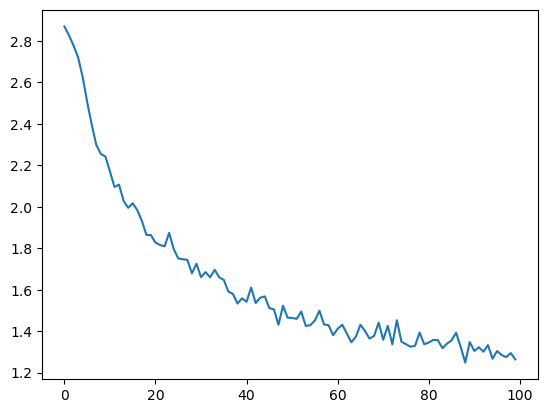

In [4]:
import time
import random
import matplotlib.pyplot as plt
import math

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0



# Example usage
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    output, loss = train(category_tensor, line_tensor)
    # Print and track the loss

plt.figure()
plt.plot(all_losses)
plt.show()

## Step 5: Evaluating the Results

/tmp/ipykernel_31992/2559070557.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/2559070557.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


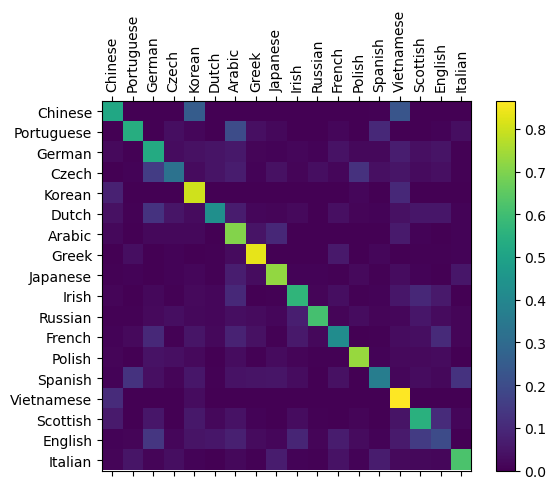

In [5]:
import matplotlib.ticker as ticker

confusion = torch.zeros(n_categories, n_categories)

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

n_confusion = 10000  # the number of samples for confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [6]:
"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Getting top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(-0.54) Chinese
(-1.04) Korean
(-4.41) Vietnamese

> Jackson
(-0.38) Scottish
(-1.66) English
(-3.23) Russian

> Satoshi
(-1.26) Arabic
(-1.47) Japanese
(-1.76) Italian


## Task 1:
Involves deriving the MomentumRNN and explaining why it can overcome the vanishing gradient problem.

In the standard RNN update equation, the hidden state at time step t, denoted as h_t, is computed by applying a non-linear activation function (σ) to the sum of two terms: the weighted sum of the previous hidden state (Uh_(t−1)) and the weighted input at the current time step (Wx_t).

To introduce momentum into the RNN, we modify the update equation by adding a momentum term. The hidden state of the MomentumRNN follows the dynamics:

v_t = µv_t + sWx_(t−1)
h_t = σ(Uh_(t−1) + v_t)

In the above equations, v_t represents the momentum term, µ is the momentum coefficient, s is a scaling factor, W is the weight matrix, x_(t−1) is the input at the previous time step, U is the weight matrix for the hidden state, and h_(t−1) is the previous hidden state.

The momentum term (v_t) is updated based on the previous momentum term (v_(t−1)) and the weighted input at the previous time step (Wx_(t−1)). This mimics the concept of momentum in gradient descent optimization, where the velocity term is accumulated over time based on the past gradients.

The addition of the momentum term in the hidden state update allows the RNN to effectively propagate information through time. It helps overcome the vanishing gradient problem by addressing the issue of diminishing gradients during backpropagation through long sequences. By accumulating the momentum term, the RNN can preserve and carry information from earlier time steps, which facilitates gradient flow and helps in capturing long-term dependencies.

The momentum term acts as a "shortcut" path for gradient flow, enabling the network to retain and utilize information from distant time steps. This mechanism enhances the ability of the network to capture long-range dependencies and alleviates the vanishing gradient problem, which is crucial for tasks involving long sequences or dependencies.

------------------------------------------------------------------------------------------------------------------
To derive the MomentumRNN, by considering the update equation of the hidden state in a standard RNN:
h_t = σ(Uh_(t−1) + W x_t)

Now, the velocity term v_t and modify the update equation to include momentum:

v_t = µv_(t-1) + sW x_(t-1)
h_t = σ(Uh_(t−1) + v_t)

Here, µ represents the momentum coefficient, and s is a scaling factor for the input. The velocity v_t is updated based on the previous velocity v_(t-1) and the input x_(t-1) multiplied by the weight matrix W. The hidden state h_t is then computed using the modified update equation, including the velocity term.

To understand why MomentumRNN can help overcome the vanishing gradient problem, while considering the effect of momentum on the gradient during backpropagation. The gradient of the hidden state with respect to time can be expressed as:

∂h_t / ∂h_(t-1) = U^T * diag(σ'(Uh_(t-1) + v_t))

In this equation, U^T represents the transpose of the weight matrix U, and diag(σ'(Uh_(t-1) + v_t)) is a diagonal matrix with the derivatives of the activation function σ applied to the input.

When performing backpropagation through time, the gradient is repeatedly multiplied by U^T and diag(σ'(Uh_(t-1) + v_t)). Due to the multiplication with U^T, the gradient can potentially vanish or explode over time, depending on the eigenvalues of U.

The introduction of the velocity term v_t in MomentumRNN helps mitigate the vanishing gradient problem. The velocity term acts as a momentum vector that carries information from previous time steps and adds it to the current update. This additional term, scaled by the coefficient µ, allows the gradient to accumulate and propagate over time, overcoming the vanishing gradient issue.

https://en.wikipedia.org/wiki/Vanishing_gradient_problem

## MomentumRNN

In [7]:
import torch
import torch.nn as nn

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum_coefficient, scaling_factor, dropout_rate=0.5):
        super(MomentumRNN, self).__init__()
        self.hidden_size = hidden_size
        self.momentum_coefficient = momentum_coefficient
        self.scaling_factor = scaling_factor

        self.U = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, hidden, momentum):
        v = momentum * hidden + self.scaling_factor * self.W(x)
        hidden = self.activation(self.U(hidden) + self.dropout(v))  # Apply dropout
        output = self.linear(hidden)
        return output, hidden, v

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Define the parameters
n_hidden = 128
momentum_coefficient = 0.9
scaling_factor = 0.1

# Create an instance of the MomentumRNN
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories, momentum_coefficient, scaling_factor)

## MomentumRNN Training

In [9]:
#the loss function
criterion = nn.CrossEntropyLoss()

#the optimizer
optimizer = torch.optim.SGD(momentum_rnn.parameters(), lr=learning_rate)


# Within the train_momentum_rnn function
def train_momentum_rnn(category_tensor, line_tensor, hidden, momentum):
    momentum_rnn.zero_grad()
    loss = 0

    for i in range(line_tensor.size()[0]):
        output, hidden, momentum = momentum_rnn(line_tensor[i], hidden, momentum)
        loss += criterion(output, category_tensor)

    loss /= line_tensor.size()[0]  # Divide the loss by the sequence length

    optimizer.zero_grad()  # Zero out the gradients
    loss.backward(retain_graph=True)  # Perform backward pass with retain_graph=True
    optimizer.step()  # Update the parameters

    return output, loss.item(), hidden.detach().clone(), momentum.detach().clone()

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keeping track of losses for plotting
current_loss = 0
momentum_rnn_losses = []

hidden = momentum_rnn.initHidden()
momentum = torch.zeros_like(hidden)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, momentum = train_momentum_rnn(category_tensor, line_tensor, hidden, momentum)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Adding current loss avg to list of losses
    if iter % plot_every == 0:
        momentum_rnn_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 2.9845 Martin / Vietnamese ✗ (Scottish)
10000 10% (0m 25s) 2.8805 Rojas / English ✗ (Spanish)
15000 15% (0m 35s) 2.9300 Shadid / German ✗ (Arabic)
20000 20% (0m 46s) 2.9021 Caro / Chinese ✗ (Spanish)
25000 25% (0m 56s) 2.9109 Hardy / Scottish ✗ (French)
30000 30% (1m 6s) 2.8095 Rinn / Portuguese ✗ (Irish)
35000 35% (1m 16s) 2.8925 Kilshaw / Italian ✗ (English)
40000 40% (1m 26s) 2.9573 Sui / Italian ✗ (Chinese)
45000 45% (1m 36s) 2.7751 Araujo / Italian ✗ (Spanish)
50000 50% (1m 49s) 2.9925 Imamura / French ✗ (Japanese)
55000 55% (2m 1s) 3.0110 Amstel / French ✗ (Dutch)
60000 60% (2m 12s) 2.9289 Bekyros / Korean ✗ (Greek)
65000 65% (2m 22s) 2.9666 Tuttle / Greek ✗ (English)
70000 70% (2m 33s) 3.0083 Ding / Irish ✗ (Chinese)
75000 75% (2m 44s) 2.9126 Stary / Japanese ✗ (Czech)
80000 80% (2m 55s) 2.6728 Koch / Scottish ✗ (German)
85000 85% (3m 6s) 2.9221 Ogterop / Irish ✗ (Dutch)
90000 90% (3m 18s) 2.9231 Mckenzie / Italian ✗ (Scottish)
95000 95% (3m 28s) 2.9069 Cornett 

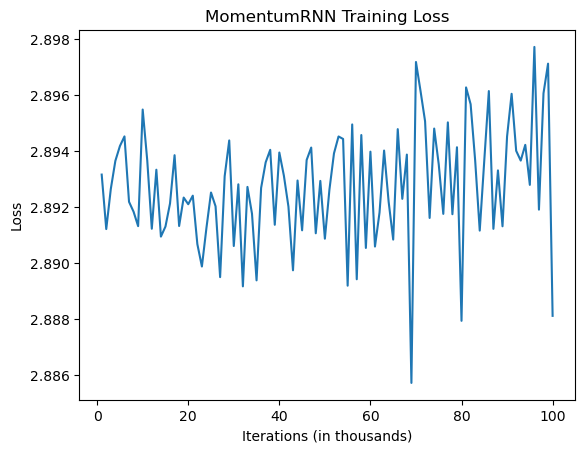

In [10]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure()
plt.plot(range(1, len(momentum_rnn_losses) + 1), momentum_rnn_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Loss')
plt.title('MomentumRNN Training Loss')
plt.show()


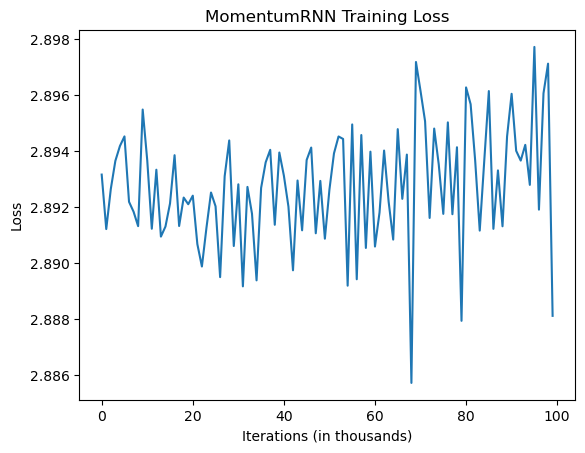

In [11]:
plt.figure()
plt.plot(momentum_rnn_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Loss')
plt.title('MomentumRNN Training Loss')
plt.show()


/tmp/ipykernel_31992/2669645455.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/2669645455.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


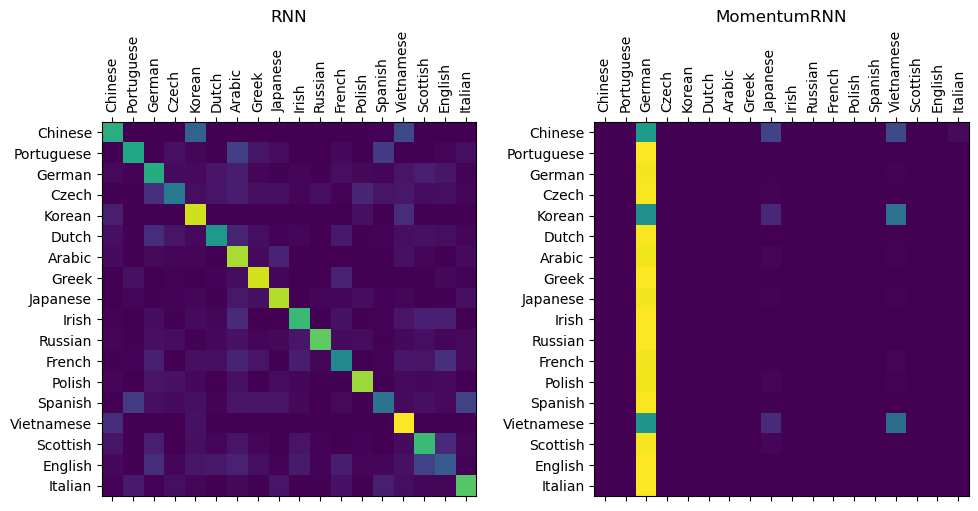

In [12]:
# Create confusion matrices for both models
confusion_rnn = torch.zeros(n_categories, n_categories)
confusion_momentum_rnn = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Evaluation function for RNN
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Evaluation function for MomentumRNN
def evaluate_momentum_rnn(line_tensor):
    hidden = momentum_rnn.initHidden()
    momentum = torch.zeros_like(hidden)

    for i in range(line_tensor.size()[0]):
        output, hidden, momentum = momentum_rnn(line_tensor[i], hidden, momentum)

    return output

# Evaluation loop for RNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_rnn = evaluate_rnn(line_tensor)
    guess_rnn, guess_i_rnn = categoryFromOutput(output_rnn)
    category_i = all_categories.index(category)
    confusion_rnn[category_i][guess_i_rnn] += 1

# Evaluation loop for MomentumRNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_rnn = evaluate_momentum_rnn(line_tensor)
    guess_momentum_rnn, guess_i_momentum_rnn = categoryFromOutput(output_momentum_rnn)
    category_i = all_categories.index(category)
    confusion_momentum_rnn[category_i][guess_i_momentum_rnn] += 1

# Normalizing the confusion matrices by dividing every row by its sum
confusion_rnn = confusion_rnn / confusion_rnn.sum(dim=1, keepdim=True)
confusion_momentum_rnn = confusion_momentum_rnn / confusion_momentum_rnn.sum(dim=1, keepdim=True)

# Set up subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
titles = ['RNN', 'MomentumRNN']
confusion_matrices = [confusion_rnn, confusion_momentum_rnn]

# Ploting confusion matrices for RNN and MomentumRNN
for i, ax in enumerate(axes):
    ax.matshow(confusion_matrices[i].numpy())
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()


In [13]:
def predict_momentum_rnn(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        line_tensor = lineToTensor(input_line)
        hidden = momentum_rnn.initHidden()
        momentum = torch.zeros_like(hidden)

        for i in range(line_tensor.size()[0]):
            output, hidden, momentum = momentum_rnn(line_tensor[i], hidden, momentum)

        # Getting top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

    return predictions

## classification_report, accuracy_score

In [18]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluation function for RNN
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Evaluation function for MomentumRNN
def evaluate_momentum_rnn(line_tensor):
    hidden = momentum_rnn.initHidden()
    momentum = torch.zeros_like(hidden)

    for i in range(line_tensor.size()[0]):
        output, hidden, momentum = momentum_rnn(line_tensor[i], hidden, momentum)

    return output

# Lists to store predicted and true labels
predicted_rnn = []
predicted_momentum_rnn = []
true_labels = []
true_labels_momentum = [] 

# Evaluation loop for RNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_rnn = evaluate_rnn(line_tensor)
    guess_rnn, _ = categoryFromOutput(output_rnn)
    predicted_rnn.append(guess_rnn)
    true_labels.append(category)

# Evaluation loop for MomentumRNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_rnn = evaluate_momentum_rnn(line_tensor)
    guess_momentum_rnn, _ = categoryFromOutput(output_momentum_rnn)
    predicted_momentum_rnn.append(guess_momentum_rnn)
    true_labels_momentum.append(category)


    
# Print classification report and accuracy for RNN
print("RNN Performance:")
print(classification_report(true_labels, predicted_rnn))
print("Accuracy:", accuracy_score(true_labels, predicted_rnn))

# Print classification report and accuracy for MomentumRNN
print("MomentumRNN Performance:")
print(classification_report(true_labels_momentum, predicted_momentum_rnn))
print("Accuracy:", accuracy_score(true_labels_momentum, predicted_momentum_rnn))


RNN Performance:
              precision    recall  f1-score   support

      Arabic       0.47      0.73      0.57       566
     Chinese       0.59      0.54      0.56       573
       Czech       0.49      0.28      0.35       560
       Dutch       0.72      0.49      0.58       554
     English       0.32      0.25      0.28       562
      French       0.52      0.42      0.46       536
      German       0.39      0.45      0.42       544
       Greek       0.76      0.83      0.79       555
       Irish       0.64      0.57      0.60       541
     Italian       0.66      0.61      0.64       579
    Japanese       0.71      0.73      0.72       573
      Korean       0.53      0.81      0.64       509
      Polish       0.75      0.74      0.75       602
  Portuguese       0.67      0.59      0.63       574
     Russian       0.87      0.72      0.79       534
    Scottish       0.55      0.56      0.56       556
     Spanish       0.56      0.39      0.46       538
  Vietname

/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## the confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix

# Evaluation loop for RNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_rnn = evaluate_rnn(line_tensor)
    guess_rnn, _ = categoryFromOutput(output_rnn)
    predicted_rnn.append(guess_rnn)
    true_labels.append(category)

# Evaluation loop for MomentumRNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_rnn = evaluate_momentum_rnn(line_tensor)
    guess_momentum_rnn, _ = categoryFromOutput(output_momentum_rnn)
    predicted_momentum_rnn.append(guess_momentum_rnn)

# Computing confusion matrix for RNN
confusion_rnn = confusion_matrix(true_labels, predicted_rnn)

# Computing confusion matrix for MomentumRNN
confusion_momentum_rnn = confusion_matrix(true_labels, predicted_momentum_rnn)

# Print confusion matrix for RNN
print("Confusion Matrix - RNN:")
print(confusion_rnn)

# Print confusion matrix for MomentumRNN
print("Confusion Matrix - MomentumRNN:")
print(confusion_momentum_rnn)


Confusion Matrix - RNN:
[[823  29  13   0   0   0  17  42   0  15  87  14   0   0   0  13   0  56]
 [  0 597   0   0   0   0   0   0   0   0   0 263   2   0   0   0   6 243]
 [ 74   1 338  42  55  20 157  20  19  12  41  49 109  14  31  47  34  52]
 [ 95  26  41 501  50  41 145  14  30  14  10  26  12  11   0  40   8  36]
 [ 75  17  15  71 267  70 120  30  88   5   5  56  25  13  17 168   6  67]
 [109   9   3  17 117 447 113  39  58  14   0  41   0  25   8  43   2  50]
 [ 76  20  46  61  81  27 549  19  11  11  14  53  23  11   9  42  10  82]
 [ 18   0  11  12   6  70   0 882   0  16  11   0   0  33   0   4  10   7]
 [ 92  16   4  10  75  53  36   9 654   0   4  31   4   0   6  80   9  45]
 [ 27  16  26   0  17  30  16   3  11 670  61  10  11  68   1  22  74  22]
 [ 71   4  10   2   5   3   3  25   4  60 826  18  48   9  11   2   9  26]
 [  0  91   0   0   0   0   0   0   0   0   0 880  21   0   0   0   0 117]
 [ 34  19  51   0  24   7  46   7  10   0  29  21 833   0   7  11   7  16]
 

## LSTM model

In [21]:
"""
Repeat the above steps with the LSTM model
"""

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size

        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=False,
        )
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        lstm,_ = self.LSTM(x) 
        out = self.linear(lstm[-1, :, :])
        #output =self.softmax(out)
        return out

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
#criterion = nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

learning_rate = 0.005 # If this is too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):
    lstm.zero_grad()

    #for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Adding parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keeping track of losses for plotting
current_loss = 0
lstm_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # AddING current loss avg to list of losses
    if iter % plot_every == 0:
        lstm_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.8694 Calogerakis / Czech ✗ (Greek)
10000 10% (0m 16s) 2.8237 Mclaughlin / Irish ✗ (Scottish)
15000 15% (0m 24s) 2.8442 Toman / Scottish ✗ (Czech)
20000 20% (0m 32s) 2.7703 Janacek / Dutch ✗ (Czech)
25000 25% (0m 41s) 2.5850 Thach / Chinese ✗ (Vietnamese)
30000 30% (0m 50s) 3.0994 Lidval / Japanese ✗ (Russian)
35000 35% (0m 59s) 2.5265 Ramires / Greek ✗ (Portuguese)
40000 40% (1m 8s) 1.2495 Rui / Korean ✗ (Chinese)
45000 45% (1m 17s) 1.1602 Sun / Chinese ✗ (Korean)
50000 50% (1m 26s) 2.7047 Tifft / Arabic ✗ (German)
55000 55% (1m 35s) 1.7623 Mendoza / Czech ✗ (Spanish)
60000 60% (1m 45s) 0.5172 Damhan / Irish ✓
65000 65% (1m 55s) 3.9317 Konig / Korean ✗ (German)
70000 70% (2m 4s) 1.3180 Lew / Korean ✗ (Chinese)
75000 75% (2m 13s) 0.9389 Abello / Spanish ✓
80000 80% (2m 24s) 1.5222 Vinnik / Czech ✗ (Russian)
85000 85% (2m 33s) 0.0644 Tukvachinsky / Russian ✓
90000 90% (2m 43s) 2.6088 Beek / Korean ✗ (Dutch)
95000 95% (2m 52s) 1.0775 Samios / Greek ✓
100000 100% (3m 2s) 

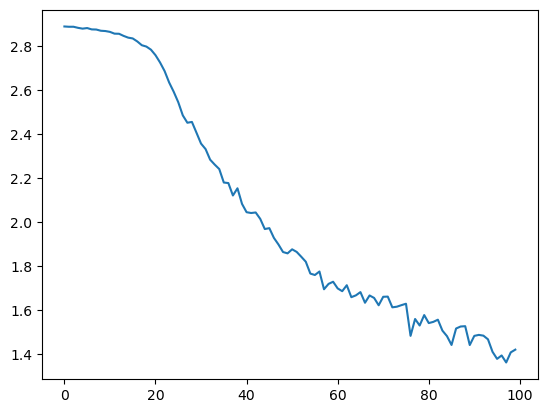

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)

/tmp/ipykernel_31992/604663836.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/604663836.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


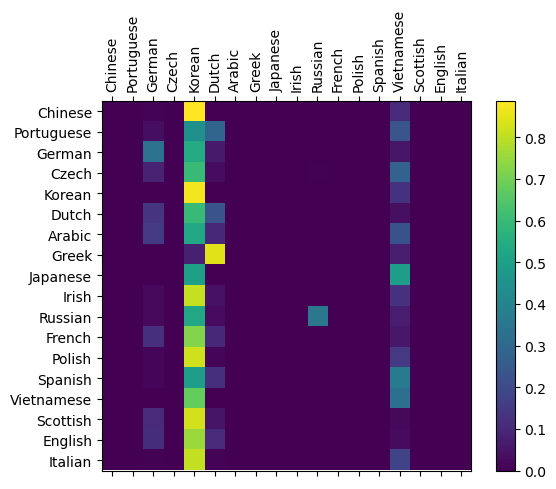

In [24]:
'''
Evaluating the results'''
import matplotlib.ticker as ticker

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plot the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [25]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = lstm(lineToTensor(input_line))

        # Getting top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(5.43) Chinese
(4.98) Korean
(4.51) Vietnamese

> Jackson
(5.46) Scottish
(4.11) English
(3.11) German

> Satoshi
(5.62) Japanese
(4.59) Arabic
(3.89) Italian


## MomentumLSTM

In [26]:
import torch
import torch.nn as nn

class MomentumLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum_coefficient, scaling_factor):
        super(MomentumLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.momentum_coefficient = momentum_coefficient
        self.scaling_factor = scaling_factor

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, x, hidden, momentum):
        output, hidden = self.lstm(x, hidden)
        hidden, cell_state = hidden
        v = momentum * hidden + self.scaling_factor * output
        hidden = self.activation(v)
        output = self.linear(hidden)
        return output, (hidden, cell_state), v

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)


# Defining the parameters
n_hidden = 128
momentum_coefficient = 0.9
scaling_factor = 0.1

# Creating an instance of the MomentumLSTM
momentum_lstm = MomentumLSTM(n_letters, n_hidden, n_categories, momentum_coefficient, scaling_factor)


In [29]:
# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Defining the optimizer
optimizer = torch.optim.SGD(momentum_lstm.parameters(), lr=learning_rate)



# Within the train_momentum_lstm function
def train_momentum_lstm(category_tensor, line_tensor, hidden, cell_state, momentum):
    momentum_lstm.zero_grad()
    loss = 0

    for i in range(line_tensor.size()[0]):
        output, (hidden, cell_state), momentum = momentum_lstm(line_tensor[i].view(1, 1, -1), (hidden, cell_state), momentum)
        loss += criterion(output.view(1, -1), category_tensor)

    loss /= line_tensor.size()[0]  # Divide the loss by the sequence length

    optimizer.zero_grad()  # Zero out the gradients
    loss.backward(retain_graph=True)  # Perform backward pass with retain_graph=True
    optimizer.step()  # Update the parameters

    return output, loss.item(), hidden.detach().clone(), cell_state.detach().clone(), momentum.detach().clone()


n_iters = 100000
print_every = 5000
plot_every = 1000

# Keeping track of losses for plotting
current_loss = 0
momentum_lstm_losses = []

hidden, cell_state = momentum_lstm.initHidden()
momentum = torch.zeros_like(hidden)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, cell_state, momentum = train_momentum_lstm(category_tensor, line_tensor, hidden, cell_state, momentum)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output.view(1, -1))
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Adding current loss avg to list of losses
    if iter % plot_every == 0:
        momentum_lstm_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.9047 Zhou / Vietnamese ✗ (Chinese)
10000 10% (0m 36s) 2.8714 Cao / Polish ✗ (Vietnamese)
15000 15% (0m 55s) 2.8456 Holodkovsky / French ✗ (Russian)
20000 20% (1m 13s) 2.9372 Whyte / Vietnamese ✗ (Scottish)
25000 25% (1m 30s) 2.8648 Papageorge / French ✗ (Greek)
30000 30% (1m 48s) 2.9194 Plamondon / Russian ✗ (French)
35000 35% (2m 6s) 2.8819 Thach / Italian ✗ (Vietnamese)
40000 40% (2m 31s) 2.9005 Mcdonnell / German ✗ (English)
45000 45% (2m 51s) 2.8789 Janda / English ✗ (Polish)
50000 50% (3m 9s) 2.9087 Soldati / German ✗ (Italian)
55000 55% (3m 27s) 2.9457 Brodeur / Greek ✗ (French)
60000 60% (3m 46s) 2.9329 Zientek / Italian ✗ (Polish)
65000 65% (4m 5s) 2.9691 Names / Russian ✗ (Irish)
70000 70% (4m 23s) 2.9667 O'Rourke / Chinese ✗ (Irish)
75000 75% (4m 43s) 2.8626 Kwei / French ✗ (Chinese)
80000 80% (5m 2s) 2.9061 OwYang / Portuguese ✗ (Chinese)
85000 85% (5m 22s) 2.8346 Kourempes / English ✗ (Greek)
90000 90% (5m 41s) 2.8291 Thi / Vietnamese ✓
95000 95% (5m 59s)

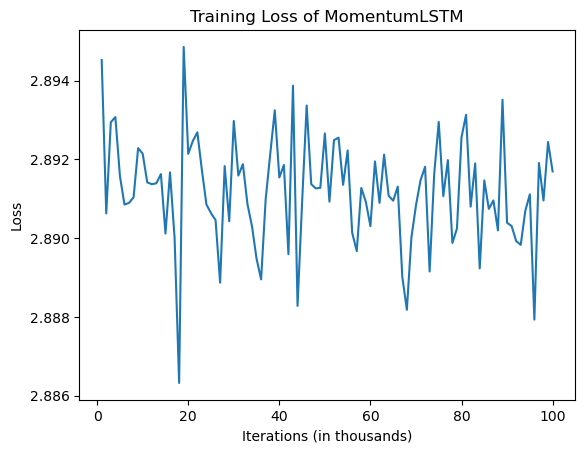

In [30]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure()
plt.plot(range(1, len(momentum_lstm_losses) + 1), momentum_lstm_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Loss')
plt.title('Training Loss of MomentumLSTM')
plt.show()

In [31]:
def predict_momentum_lstm(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        input_tensor = input_tensor.unsqueeze(0)  # Adding batch dimension
        hidden = momentum_lstm.initHidden()

        for i in range(input_tensor.size()[1]):
            output, hidden, _ = momentum_lstm(input_tensor[:, i], hidden, momentum)

        # Getting top N categories
        topv, topi = output.topk(n_predictions, dim=2)  # Updated indexing
        predictions = []

        for i in range(n_predictions):
            value = topv[0][0][i].item()  # Updated indexing
            category_index = topi[0][0][i].item()  # Updated indexing
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict_momentum_lstm('Yuan')
predict_momentum_lstm('Jackson')
predict_momentum_lstm('Satoshi')



> Yuan
(0.06) Italian
(0.06) Japanese
(0.02) Scottish

> Jackson
(0.06) Italian
(0.06) Japanese
(0.02) Scottish

> Satoshi
(0.06) Italian
(0.06) Japanese
(0.02) Scottish


/tmp/ipykernel_31992/1888530350.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/1888530350.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


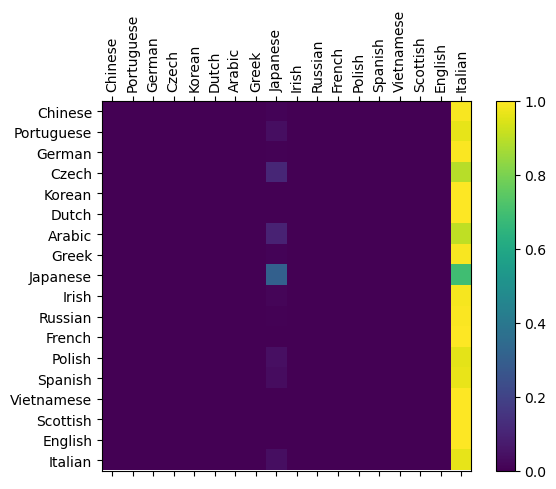

In [32]:
import matplotlib.ticker as ticker

# Initializing the confusion matrix
confusion = torch.zeros(n_categories, n_categories)

def evaluate_momentum_lstm(line_tensor):
    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden, _ = momentum_lstm(line_tensor[i].unsqueeze(0), hidden, momentum)

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_momentum_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Plotting the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


/tmp/ipykernel_31992/1951208270.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/1951208270.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([''] + all_categories)
/tmp/ipykernel_31992/1951208270.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_31992/1951208270.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([''] + all_categories)


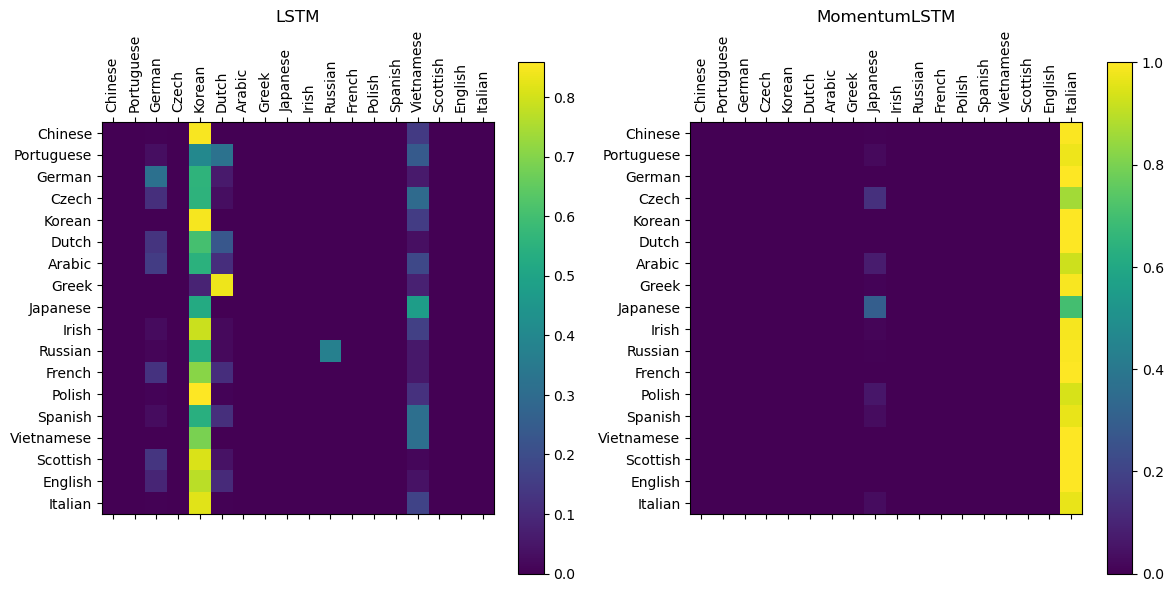

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Evaluate LSTM
# Initialize the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        # No hidden state is returned by the LSTM model, so we skip the hidden state update

    return output

n_confusion = 10000  # Define the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()
    
    
    
    
# Evaluating MomentumLSTM
confusion_momentum_lstm = torch.zeros(n_categories, n_categories)

def evaluate_momentum_lstm(line_tensor):
    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden, _ = momentum_lstm(line_tensor[i].unsqueeze(0), hidden, momentum)

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_momentum_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_momentum_lstm[category_i][guess_i] += 1



for i in range(n_categories):
    confusion_momentum_lstm[i] = confusion_momentum_lstm[i] / confusion_momentum_lstm[i].sum()

    
    
# Plotting the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
cax1 = ax1.matshow(confusion_lstm.numpy())
cax2 = ax2.matshow(confusion_momentum_lstm.numpy())
fig.colorbar(cax1, ax=ax1)
fig.colorbar(cax2, ax=ax2)

ax1.set_title('LSTM')
ax1.set_xticklabels([''] + all_categories, rotation=90)
ax1.set_yticklabels([''] + all_categories)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.set_title('MomentumLSTM')
ax2.set_xticklabels([''] + all_categories, rotation=90)
ax2.set_yticklabels([''] + all_categories)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()
plt.show()

In [34]:
# Evaluating LSTM accuracy
total_lstm = sum(confusion_lstm.sum(dim=1))
correct_lstm = sum(confusion_lstm[i][i] for i in range(n_categories))
accuracy_lstm = correct_lstm / total_lstm

# Evaluating MomentumLSTM accuracy
total_momentum_lstm = sum(confusion_momentum_lstm.sum(dim=1))
correct_momentum_lstm = sum(confusion_momentum_lstm[i][i] for i in range(n_categories))
accuracy_momentum_lstm = correct_momentum_lstm / total_momentum_lstm

# Print accuracy results
print("LSTM Accuracy: {:.2f}%".format(accuracy_lstm * 100))
print("MomentumLSTM Accuracy: {:.2f}%".format(accuracy_momentum_lstm * 100))


LSTM Accuracy: 11.57%
MomentumLSTM Accuracy: 7.03%


## revised MomentumRNN

In [ ]:
import torch.nn as nn

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum_mu, momentum_s):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size
        self.momentum_mu = momentum_mu
        self.momentum_s = momentum_s

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, velocity):
        hidden = hidden.unsqueeze(0)  # Adding an extra dimension for batch size
        combined = torch.cat((input, hidden), 0)  # Adjusting the concatenation dimension here
        velocity = self.momentum_mu * velocity + self.momentum_s * torch.matmul(input, self.i2h.weight.t())

        hidden = self.i2h(combined) + velocity
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden.squeeze(0), velocity


    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initVelocity(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
momentum_mu = 0.9
momentum_s = 0.1
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories, momentum_mu, momentum_s)

# Training
def train(category_tensor, line_tensor, hidden, velocity):
    momentum_rnn.zero_grad()
    line_tensor = line_tensor.unsqueeze(0)  # Add an extra dimension for batch size

    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Update parameters with momentum
    for p in momentum_rnn.parameters():
        if p.requires_grad:
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item(), hidden, velocity

# Evaluation
def evaluate(line_tensor, hidden, velocity):
    line_tensor = line_tensor.unsqueeze(0)  # Add an extra dimension for batch size

    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    return output, hidden.squeeze(0), velocity

# Training loop
hidden = momentum_rnn.initHidden()
velocity = momentum_rnn.initVelocity()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, velocity = train(category_tensor, line_tensor, hidden, velocity)


In [ ]:
# Training
def train(category_tensor, line_tensor, hidden, velocity):
    momentum_rnn.zero_grad()
    line_tensor = line_tensor.unsqueeze(0)  # Add an extra dimension for batch size

    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Update parameters with momentum
    for p in momentum_rnn.parameters():
        if p.requires_grad:
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item(), hidden, velocity

# Evaluation
def evaluate(line_tensor, hidden, velocity):
    for i in range(line_tensor.size()[0]):
        output, hidden, velocity = momentum_rnn(line_tensor[i], hidden, velocity)

    return output, hidden, velocity

# Training loop
hidden = momentum_rnn.initHidden()
velocity = momentum_rnn.initVelocity()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, hidden, velocity = train(category_tensor, line_tensor, hidden, velocity)

## Revised LSTM and MomentumLSTM

In [36]:
import torch
import torch.nn as nn
import string
import random

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the last output sequence
        return output

# Prepare the data
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Define categories and names
categories = ['English', 'French', 'Spanish']
names = {
    'English': ['Smith', 'Johnson', 'Brown'],
    'French': ['Dupont', 'Leblanc', 'Lefebvre'],
    'Spanish': ['Garcia', 'Lopez', 'Rodriguez']
}

# Convert names to tensors
category_lines = {}
for category, name_list in names.items():
    lines = [lineToTensor(name) for name in name_list]
    category_lines[category] = lines

# Define the LSTM model and criterion
hidden_size = 128
output_size = len(categories)
lstm = LSTM(n_letters, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()

# Training
learning_rate = 0.005
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

def letterToIndex(letter):
    return all_letters.find(letter)


def line_tensorToName(line_tensor):
    name = ""
    for tensor in line_tensor:
        _, idx = tensor.max(dim=1)  # Fix the dimension for finding the max value
        letter = all_letters[idx.item()]
        name += letter
    return name

# Within the train function
def train(category_tensor, line_tensor):
    hidden = torch.zeros(1, 1, hidden_size)
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        hidden = output

    # Modify the category_tensor shape
    category_tensor = category_tensor.squeeze()

    loss = criterion(output.squeeze(), category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()



n_iters = 10000
print_every = 500
plot_every = 100
current_loss = 0

for iter in range(1, n_iters + 1):
    category = random.choice(categories)
    line_tensor = random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = categories[torch.argmax(output)]
        correct = '✓' if guess == category else '✗'
        print(f'{iter} {iter / n_iters * 100}% Loss: {loss:.4f} Name: {line_tensorToName(line_tensor)} Guess: {guess} {correct}')

    if iter % plot_every == 0:
        current_loss /= plot_every
        # TODO: Plot the loss

# Prediction
def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")


500 5.0% Loss: 0.9790 Name: Johnson Guess: English ✓
1000 10.0% Loss: 0.9635 Name: Johnson Guess: English ✓
1500 15.0% Loss: 1.0190 Name: Brown Guess: English ✓
2000 20.0% Loss: 1.0253 Name: Brown Guess: English ✓
2500 25.0% Loss: 1.0113 Name: Johnson Guess: English ✓
3000 30.0% Loss: 0.9925 Name: Johnson Guess: English ✓
3500 35.0% Loss: 0.9645 Name: Lopez Guess: Spanish ✓
4000 40.0% Loss: 1.0094 Name: Leblanc Guess: French ✓
4500 45.0% Loss: 0.7882 Name: Johnson Guess: English ✓
5000 50.0% Loss: 0.8961 Name: Smith Guess: English ✓
5500 55.00000000000001% Loss: 0.8548 Name: Smith Guess: English ✓
6000 60.0% Loss: 0.5912 Name: Lopez Guess: Spanish ✓
6500 65.0% Loss: 0.4148 Name: Brown Guess: English ✓
7000 70.0% Loss: 0.4061 Name: Lopez Guess: Spanish ✓
7500 75.0% Loss: 0.3553 Name: Rodriguez Guess: Spanish ✓
8000 80.0% Loss: 0.2056 Name: Brown Guess: English ✓
8500 85.0% Loss: 0.2447 Name: Lopez Guess: Spanish ✓
9000 90.0% Loss: 0.3494 Name: Smith Guess: English ✓
9500 95.0% Loss: 0.2

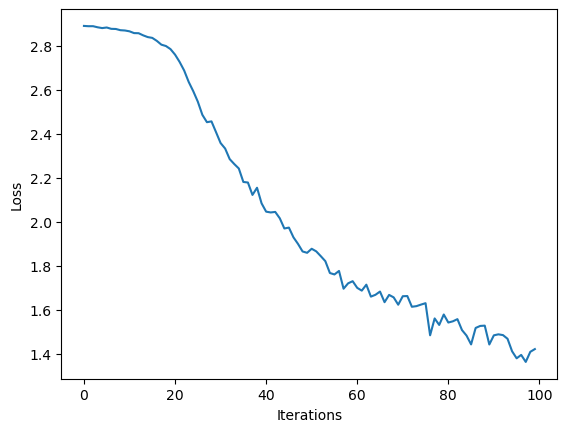

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [46]:
'''
Evaluating the results'''
import matplotlib.ticker as ticker

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plot the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

KeyError: 'Scottish'

In [38]:

def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")
# predict('Yuan')
# predict('Jackson')
# predict('Satoshi')

Input: Gomez, Predicted Category: Spanish


In [43]:
import seaborn as sns

# Evaluation
def evaluate():
    predicted_labels = []
    true_labels = []

    for category in categories:
        for line_tensor in category_lines[category]:
            output = lstm(line_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = categories[predicted.item()]
            true_label = category

            predicted_labels.append(predicted_label)
            true_labels.append(true_label)

    print(classification_report(true_labels, predicted_labels))
    print("Accuracy:", accuracy_score(true_labels, predicted_labels))

# Perform evaluation
evaluate()

# Prediction
def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")


              precision    recall  f1-score   support

     English       1.00      1.00      1.00         3
      French       1.00      1.00      1.00         3
     Spanish       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Accuracy: 1.0
Input: Gomez, Predicted Category: Spanish


              precision    recall  f1-score   support

     English       1.00      1.00      1.00         3
      French       1.00      1.00      1.00         3
     Spanish       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Accuracy: 1.0


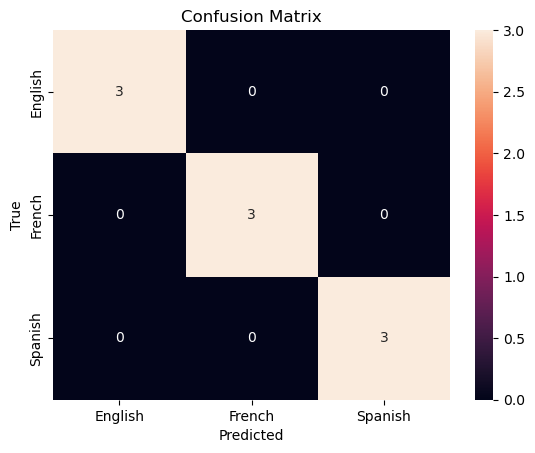

In [45]:
# Evaluation
def evaluate():
    predicted_labels = []
    true_labels = []

    for category in categories:
        for line_tensor in category_lines[category]:
            output = lstm(line_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = categories[predicted.item()]
            true_label = category

            predicted_labels.append(predicted_label)
            true_labels.append(true_label)

    print(classification_report(true_labels, predicted_labels))
    print("Accuracy:", accuracy_score(true_labels, predicted_labels))

    # Draw the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=categories)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Perform evaluation
evaluate()
